# ENSO diversity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import xesmf as xe
from eofs.xarray import Eof
import intake
import cartopy.crs as ccrs
from scipy.interpolate import LSQUnivariateSpline
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')
from scipy.signal import detrend

# models with future scenarios:
models = ['BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'MIROC-ES2L', 
          'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0',  'CESM2', 'CESM2-WACCM', 'MCM-UA-1-0']


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
# choose where to load data from:
load_data_from = 'cloud'
#load_data_from = 'glade'

if load_data_from == 'glade':
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
    col = intake.open_esm_datastore(col_url)
    #col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")


## Define functions

In [3]:
def area_weights(lat_bnds, lon_bnds): 
    # computes exact area weigths assuming earth is a perfect sphere
    lowerlats = np.radians(lat_bnds[:,0]); upperlats = np.radians(lat_bnds[:,1])
    difflon = np.radians(np.diff(lon_bnds[0,:])) # if the differences in longitudes are all the same
    areaweights = difflon*(np.sin(upperlats) - np.sin(lowerlats));
    areaweights /= areaweights.mean()
    return areaweights # list of weights, of same dimension as latitude

def numerical_midmonths(xdata):
    # converts xarray monthly time data to numpy array with numerical values
    # for use in functions that cannot use xarray times as input
    midmonths = [int(str(xdata[i])[:4]) + 0.5/12 + int(str(xdata[i])[5:7])/12 for i in range(xdata.shape[0])]
    return np.array(midmonths)


def cub_spl_monthly_detrending3D(xarray, axis=0):
    # detrending by cubic splines, 
    # specifically written for monthly mean ts data ranging from jan 1850 to dec 2100
    xdata = xarray.time.values; ydata = xarray.values # time, lat, lon
    dims = list(np.shape(ydata)); axisdim = dims[axis]; dims.pop(axis)
    times = numerical_midmonths(xdata)
    
    internal_knots = [1850 + (2014-1850)/2, 2014]
    detr_data = np.full((axisdim, dims[0], dims[1]), np.nan)
    for y in range(dims[0]):
        for x in range(dims[1]):
            gridp_data = ydata[:,y,x]
            spl = LSQUnivariateSpline(times, gridp_data, internal_knots)
            detr_data[:,y,x] = gridp_data - spl(times)    
            
    # convert back to xarray:
    detr_xarray = xr.DataArray(detr_data, coords={'time': xarray.time, 'lat': xarray.lat, 'lon': xarray.lon},
                               dims=['time', 'lat', 'lon'])
    detr_xarray = detr_xarray.to_dataset(name = 'detrended_ts')
    return detr_xarray

def sel_member(model): # finds members chosen for historical and ssp experiments
    if model in ['BCC-CSM2-MR', 'CanESM5', 'MIROC6', 'MRI-ESM2-0', 'CESM2-WACCM']:
        chosen_member = 'r1i1p1f1'
    elif model in ['MIROC-ES2L', 'CNRM-CM6-1','MCM-UA-1-0', 'UKESM1-0-LL']:
        chosen_member = 'r1i1p1f2'
    elif model in ['CNRM-ESM2-1']:
        chosen_member = 'r2i1p1f2'
    elif model in ['CESM2']:
        chosen_member = 'r4i1p1f1'
    return chosen_member

def picontrol_member(model): # finds members chosen for piControl
    if model in ['BCC-CSM2-MR', 'CanESM5', 'MIROC6', 'MRI-ESM2-0', 'MCM-UA-1-0', 'CESM2', 'CESM2-WACCM']:
        chosen_member = 'r1i1p1f1'
    elif model in ['MIROC-ES2L', 'CNRM-CM6-1', 'UKESM1-0-LL', 'CNRM-ESM2-1']:
        chosen_member = 'r1i1p1f2'
    return chosen_member

def eof_sign(array):
    testpoint = array.sel(lat = 0.5, lon = 175.5)
    if testpoint < 0:
        sign = -1
    else:
        sign = 1
    return sign

## Loop over models:

In [14]:
 # use larger region before regridding, that adds 5 deg to each border:
latregion = slice(-15,15); lonregion = slice(140, 280) # = 140 E - 80 W
larger_latregion = slice(-20,20); larger_lonregion = slice(135, 285)
resolution = 1;
ds_out = xr.Dataset({'lon': (['lon'], np.arange(lonregion.start+resolution/2, lonregion.stop+resolution/2, resolution)),
                     'lat': (['lat'], np.arange(latregion.start+resolution/2, latregion.stop+resolution/2, resolution))
                    }
                   )
regr_lat_bnds = np.array([[upper, upper+resolution] for upper in range(latregion.start,latregion.stop)])
regr_lon_bnds = np.array([[upper, upper+resolution] for upper in range(lonregion.start,lonregion.stop)])
area_w = area_weights(regr_lat_bnds, regr_lon_bnds)

# choose a model:
for model in models:
    
    #### load data ####
    exp_list = ['piControl', 'historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
    exp_keys = {}; datasets = {}
    for exp in exp_list:
        print(exp)
        if exp == 'piControl':
            member = picontrol_member(model)
        else:
            member = sel_member(model)
        cat = col.search(experiment_id = exp, source_id = model, variable_id='ts', table_id='Amon', member_id = member)
        dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})
        for key in dset_dict.keys():
            exp_keys[exp] = key
            datasets[key] = dset_dict[key]
    
    if model == 'MCM-UA-1-0': 
        exp_list = ['piControl', 'ssp245', 'ssp370', 'ssp585']
    else:
        exp_list = ['piControl', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

    #### detrend data ####
    anomalies = {}
    for exp in exp_list:
        if exp in exp_keys:
            print(model, exp)

            key = exp_keys[exp]
            if exp == 'piControl':
                member = picontrol_member(model)
                ds = datasets[key].sel(member_id = member)
                if model == 'MCM-UA-1-0':
                    ds = ds.rename({'longitude': 'lon','latitude': 'lat'})

                regional_data = ds.ts.sel(lat = larger_latregion, lon = larger_lonregion)
                regridder = xe.Regridder(regional_data, ds_out, 'bilinear', reuse_weights = True)
                regridded_data = regridder(regional_data)

                # linear detrending for first 500 years:
                ds_detr = xr.apply_ufunc(detrend, regridded_data[:500*12], kwargs={'axis': 0}, dask = 'allowed')
            else:
                member = sel_member(model)
                hist_ds = datasets[exp_keys['historical']].sel(member_id = member)
                ds = datasets[key].sel(member_id = member)
                # concatenate and make sure dataset stops in year 2100:
                ds = xr.concat([hist_ds, ds], dim = 'time').isel(time=slice(0,3012))
                # concatenate historical and ssp, where the historical part is only
                # used to get a better trend estimate in ssp period
                if model == 'MCM-UA-1-0':
                    ds = ds.rename({'longitude': 'lon','latitude': 'lat'})
                regional_data = ds.ts.sel(lat = larger_latregion, lon = larger_lonregion)
                regridder = xe.Regridder(regional_data, ds_out, 'bilinear', reuse_weights = True)
                regridded_data = regridder(regional_data) 
                # apply cubic spline detrending at every point:
                ds_detr = cub_spl_monthly_detrending3D(regridded_data, axis=0)
                # use only ssp time period from now on:
                ds_detr = ds_detr.isel(time=slice(1980,3012))

            # deseasonalise
            ts_clim = ds_detr.groupby('time.month').mean(dim='time')
            ts_anom = ds_detr.groupby('time.month') - ts_clim
            anomalies[exp] = ts_anom
            
    #### do EOF analysis ####    
    # for piControl
    data = anomalies['piControl'].transpose('time', 'lon', 'lat')
    solver = Eof(data, weights=np.sqrt(area_w))
    eofs = solver.eofs(neofs=2)
    pcs = solver.pcs(npcs=2)
    variance_fractions = solver.varianceFraction(neigs=2)
    
    # project fields from other experiments onto piControl EOFs
    for exp in exp_list[1:]:
        proj_data = anomalies[exp].detrended_ts.transpose('time', 'lon', 'lat')
        pseudo_pcs = solver.projectField(proj_data, neofs=2)
        pseudo_pcs = pseudo_pcs.to_dataset(name = model + '_' + exp + '_pseudo_pcs')
        if model == models[0] and exp == exp_list[1]:
            all_pseudo_pcs = pseudo_pcs
            ssp_time_coord = pseudo_pcs.time
        else:
            pseudo_pcs = pseudo_pcs.assign_coords(time = ssp_time_coord)
            all_pseudo_pcs = xr.merge([all_pseudo_pcs, pseudo_pcs])
    
    # include model name in variable name, and merge xarrays
    variance_fractions = variance_fractions.to_dataset(name = model + '_variance_fractions')
    eofs = eofs.to_dataset(name = model + '_eofs')
    pcs = pcs.to_dataset(name = model + '_pcs')
    
    if model in models[1:]: # then xarray already exists that we can merge with
        all_variance_fractions = xr.merge([all_variance_fractions, variance_fractions])
        all_eofs = xr.merge([all_eofs, eofs])
        # convert time axes of all pcs to the same values as the first model
        # In that way the final dataset takes up less space
        pcs = pcs.assign_coords(time = fixed_time_coord[:len(pcs.time)])
        all_pcs = xr.merge([all_pcs, pcs])
    else: # create xarrays
        all_variance_fractions = variance_fractions
        all_eofs = eofs; all_pcs = pcs;
        fixed_time_coord = pcs.time


piControl
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
historical
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
ssp126
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
ssp245
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
ssp370
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
ssp585
--> The keys in the returned di

In [15]:
# save files to netcdf:

#all_eofs.to_netcdf('../Processed_data/eof_data/piControl_2eofs.nc')
#all_pcs.to_netcdf('../Processed_data/eof_data/piControl_2pcs.nc')
#all_variance_fractions.to_netcdf('../Processed_data/eof_data/piControl_2variance_fractions.nc')
#all_pseudo_pcs.to_netcdf('../Processed_data/eof_data/ssp_pseudo_pcs.nc')

In [3]:


# load previously saved netcdf files
all_eofs = xr.open_dataset('../Processed_data/eof_data/piControl_2eofs.nc')
all_pcs = xr.open_dataset('../Processed_data/eof_data/piControl_2pcs.nc')
all_variance_fractions = xr.open_dataset('../Processed_data/eof_data/piControl_2variance_fractions.nc')
all_pseudo_pcs = xr.open_dataset('../Processed_data/eof_data/ssp_pseudo_pcs.nc')



## Plot the first two EOFs

Signs are chosen such that the patterns look like in Cai et al.

Whenever the sign is changed for an EOF, it is also changed for the PC

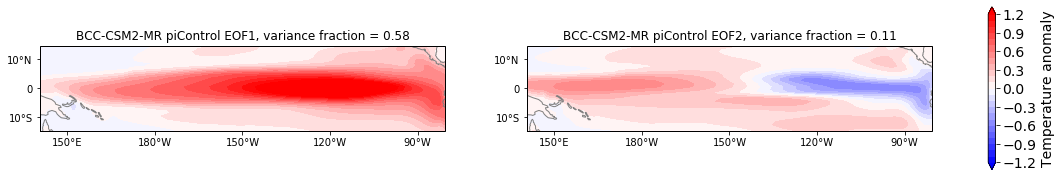

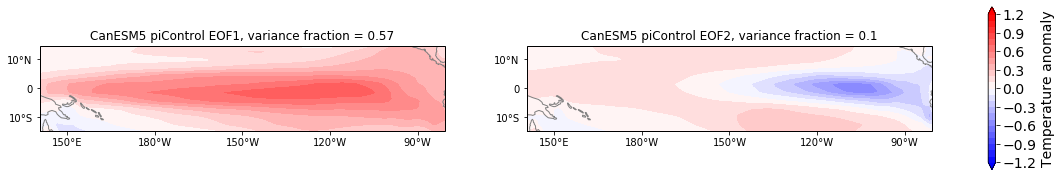

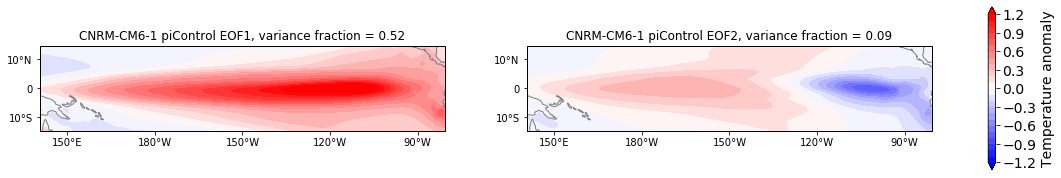

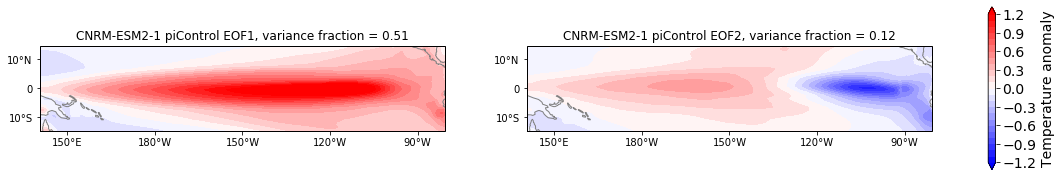

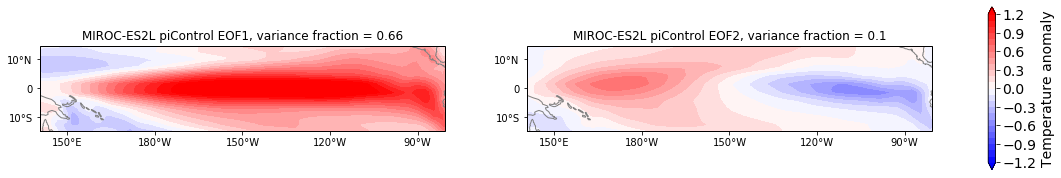

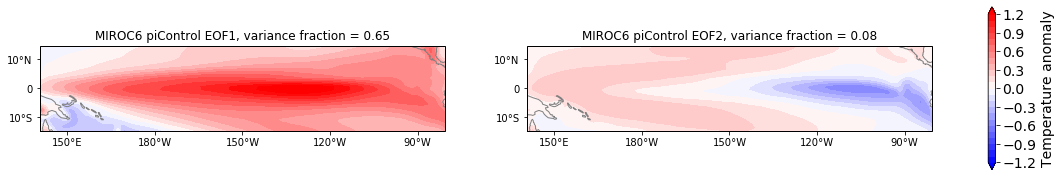

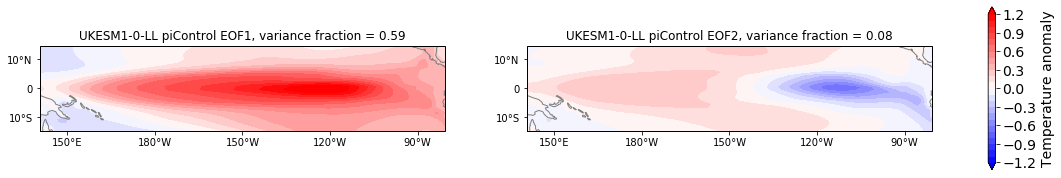

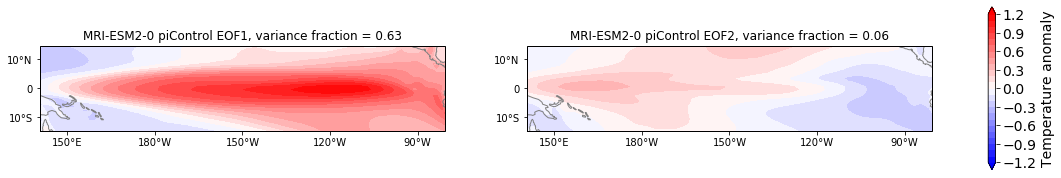

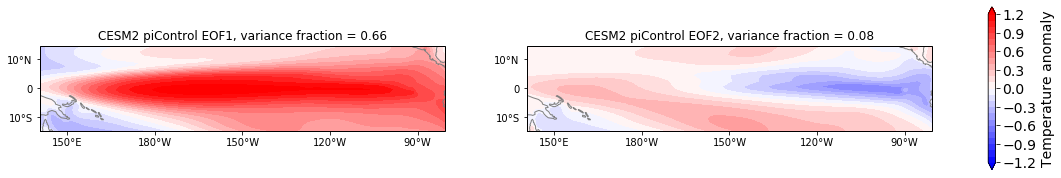

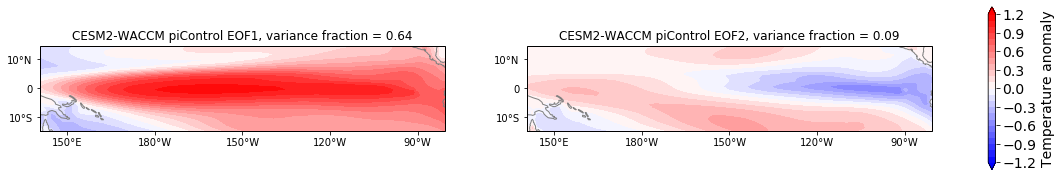

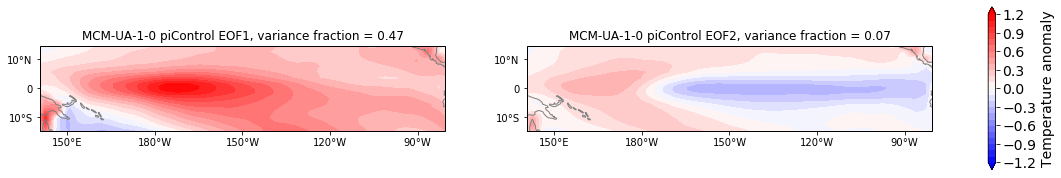

In [4]:

maxval = 1.2; step = 0.1
data_crs = ccrs.PlateCarree(central_longitude=180.0)

for model in models:
    var = model + '_eofs'; var_frac = model + '_variance_fractions'
    eof1 = all_eofs[var].sel(mode=0); var_frac1 = all_variance_fractions[var_frac].sel(mode=0).values
    eof2 = all_eofs[var].sel(mode=1); var_frac2 = all_variance_fractions[var_frac].sel(mode=1).values

    var2 = model + '_pcs'
    pc1 = all_pcs[var2].sel(mode=0)
    pc2 = all_pcs[var2].sel(mode=1)
    
    # make consistent signs:
    sign1 = eof_sign(eof1); sign2 = eof_sign(eof2)
    eof1 *= sign1; eof2 *= sign2
    pc1 *= sign1; pc2 *= sign2
    
    fig, ax = plt.subplots(ncols = 2, figsize = [20,3], subplot_kw={'projection': data_crs})
    cs0 = ax[0].contourf(all_eofs.lon, all_eofs.lat, (eof1*pc1.std()).transpose(), np.arange(-maxval,maxval+step,step), cmap = 'bwr',extend='both', transform=ccrs.PlateCarree())
    cs1 = ax[1].contourf(all_eofs.lon, all_eofs.lat, (eof2*pc2.std()).transpose(), np.arange(-maxval,maxval+step,step), cmap = 'bwr',extend='both', transform=ccrs.PlateCarree())
    for i in [0,1]:
        ax[i].coastlines(color='gray')
    cbar = fig.colorbar(cs1, ax = ax.ravel().tolist(), orientation="vertical")
    cbar.set_label('Temperature anomaly', fontsize = 14)
    cbar.ax.tick_params(labelsize = 14)
    
    ax[0].set_title(model + ' piControl EOF1, variance fraction = ' + str(np.round(var_frac1,2)))
    ax[1].set_title(model + ' piControl EOF2, variance fraction = ' + str(np.round(var_frac2,2)))
    
    plt.setp(ax, xticks = np.arange(150, 280, 30)-180, xticklabels = ['150°E', '180°W', '150°W', '120°W', '90°W'])
    plt.setp(ax, yticks = [-10, 0, 10], yticklabels = ['10°S', '0', '10°N'])
    

## Plot corresponding principal components

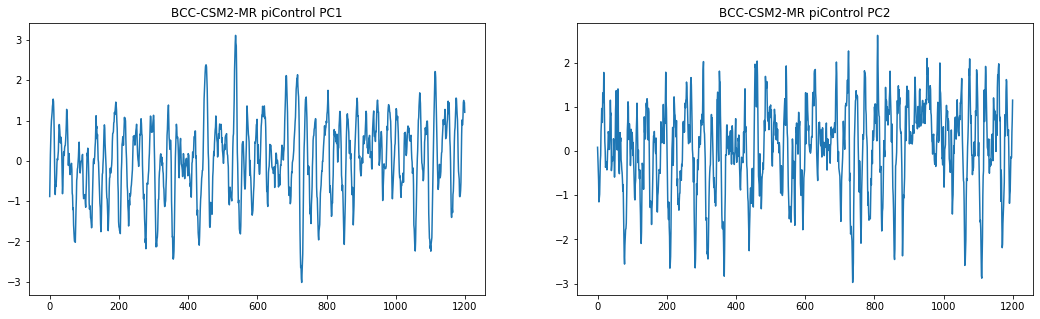

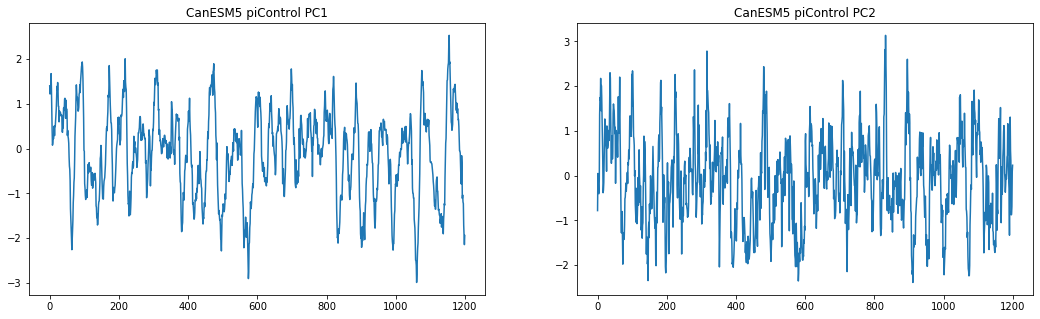

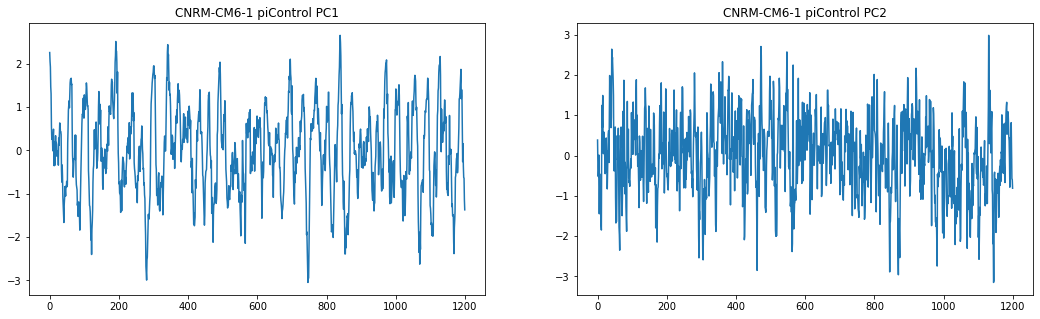

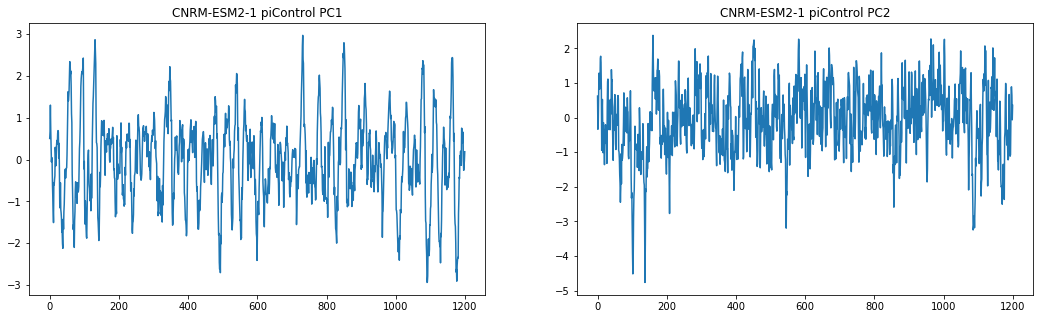

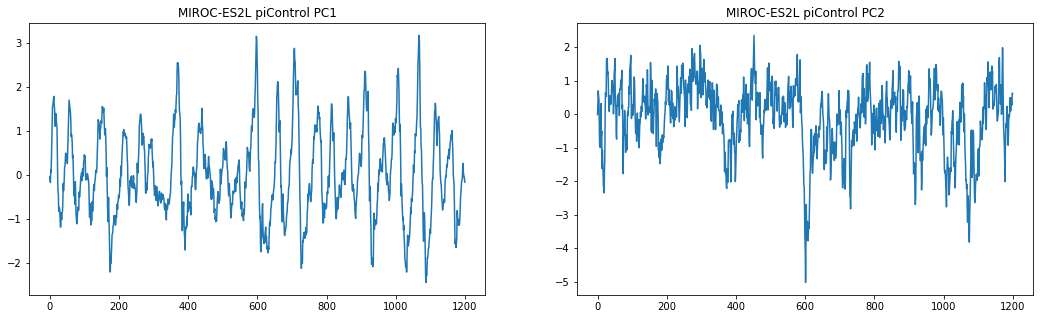

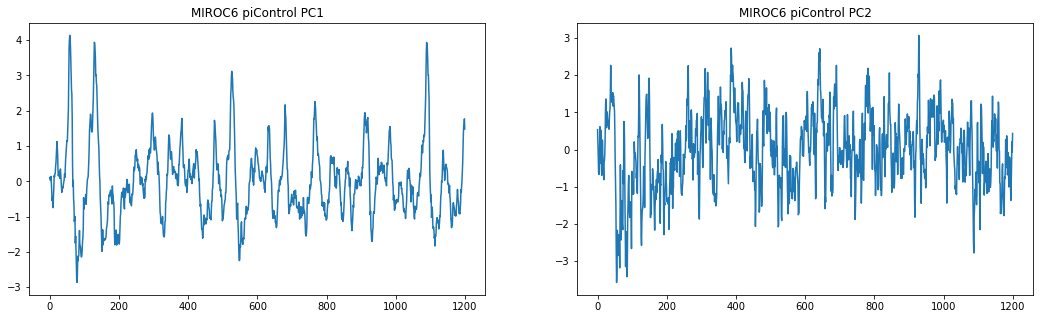

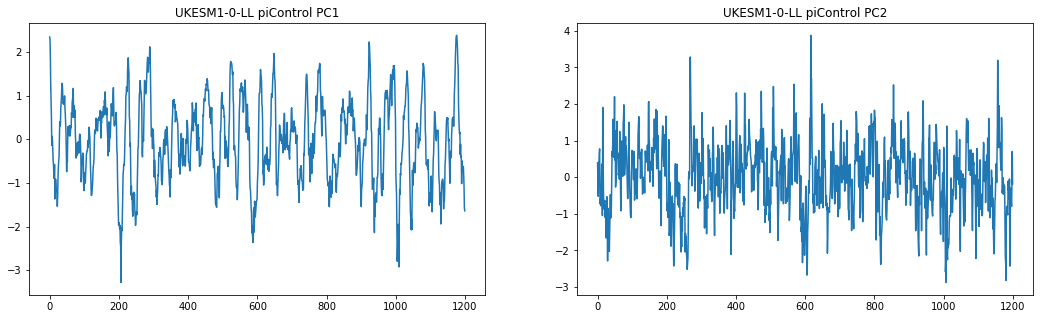

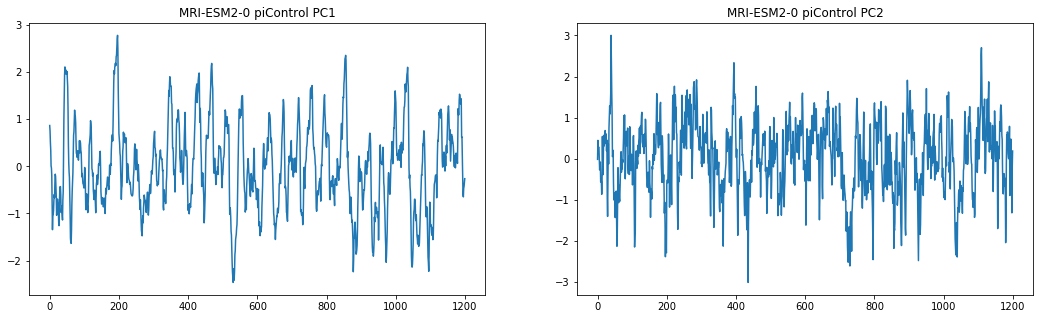

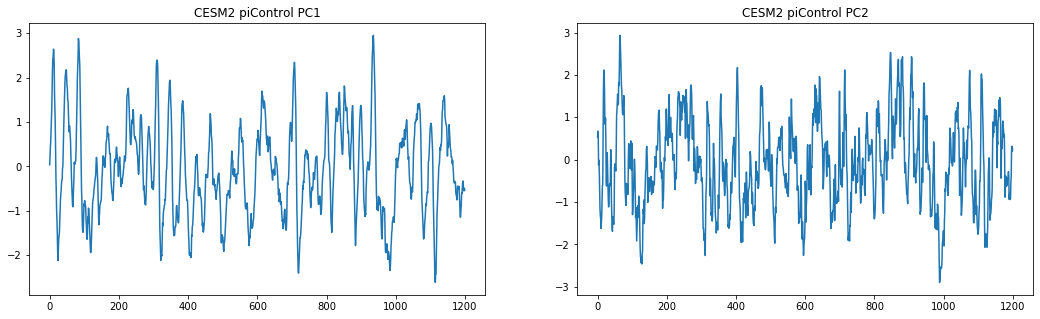

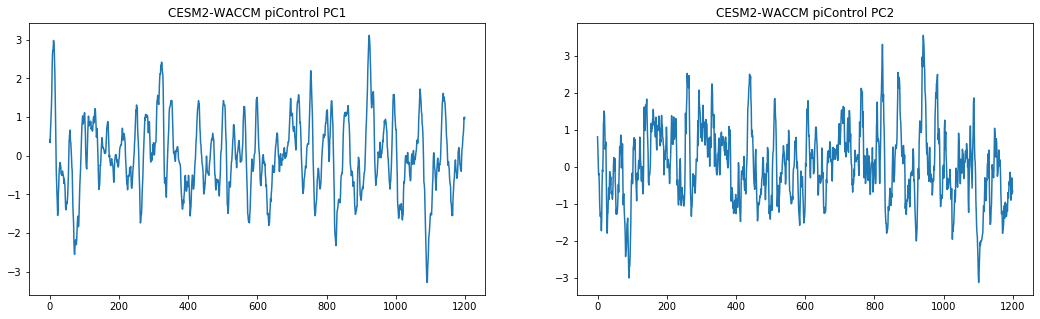

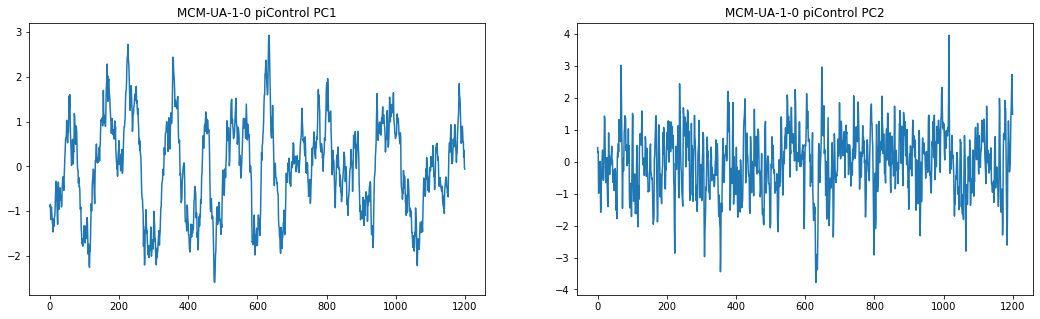

In [5]:
for model in models:
    
    var = model + '_eofs';
    eof1 = all_eofs[var].sel(mode=0)
    eof2 = all_eofs[var].sel(mode=1)

    var2 = model + '_pcs'
    pc1 = all_pcs[var2].sel(mode=0)
    pc2 = all_pcs[var2].sel(mode=1)
    
    # make consistent signs:
    sign1 = eof_sign(eof1); sign2 = eof_sign(eof2)
    eof1 *= sign1; eof2 *= sign2
    pc1 *= sign1; pc2 *= sign2
    
    fig, ax = plt.subplots(ncols = 2, figsize = [18,5])
    
    ax[0].plot(pc1[:100*12]/pc1.std())
    ax[1].plot(pc2[:100*12]/pc2.std())
    
    ax[0].set_title(model + ' piControl PC1')
    ax[1].set_title(model + ' piControl PC2')
        
    

## Scatter-plots of principal components

In [6]:
n_pc1 = pc1/pc1.std(); n_pc2 = pc2/pc2.std()
eindex = (n_pc1 - n_pc2)/np.sqrt(2)
eindex.shape

(6000,)

In [7]:
def std_spread(x):
    seg_length = 86*12; overlap = seg_length - 30*12;
    starttimes = np.arange(0,len(x)-seg_length+1,seg_length - overlap)
    segment_std_list = np.full(len(starttimes), np.nan)
    for (i,k) in enumerate(starttimes):
        segment = x[k:k+seg_length]; segment_std_list[i] = segment.std()
    
    return [segment_std_list.min(), segment_std_list.max()]

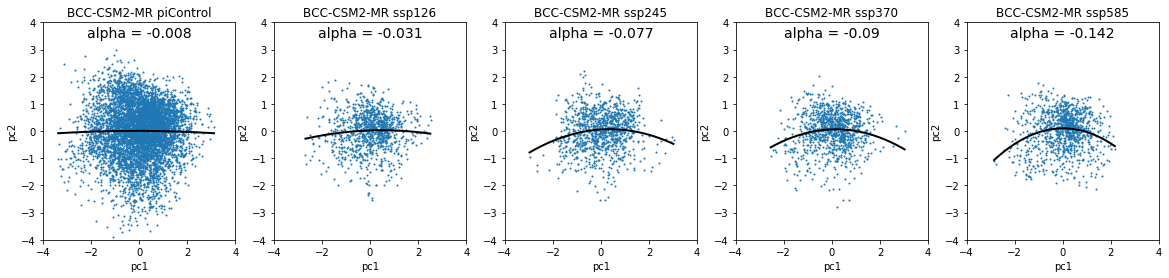

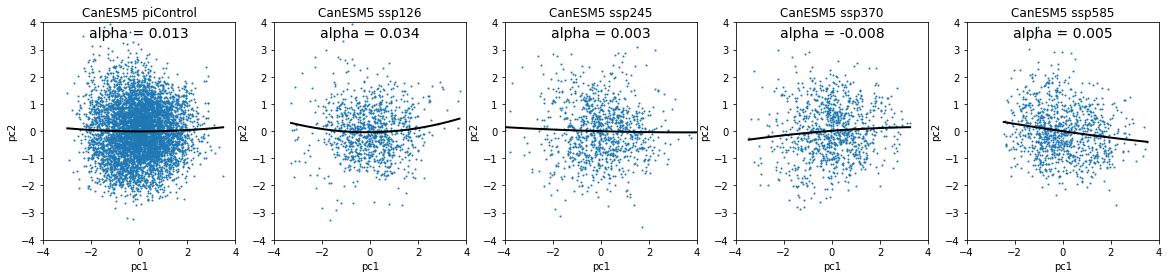

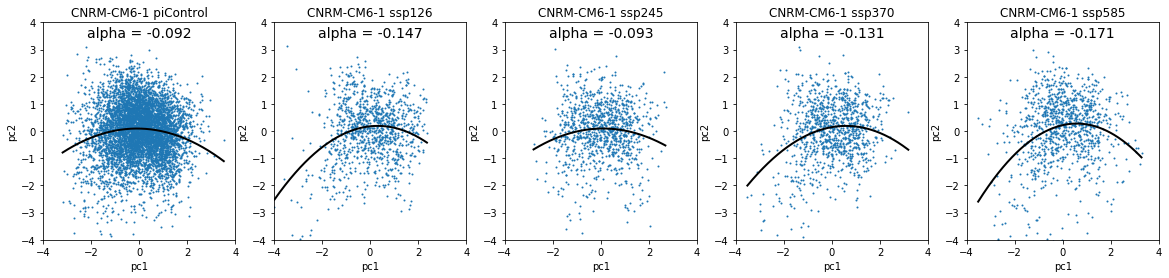

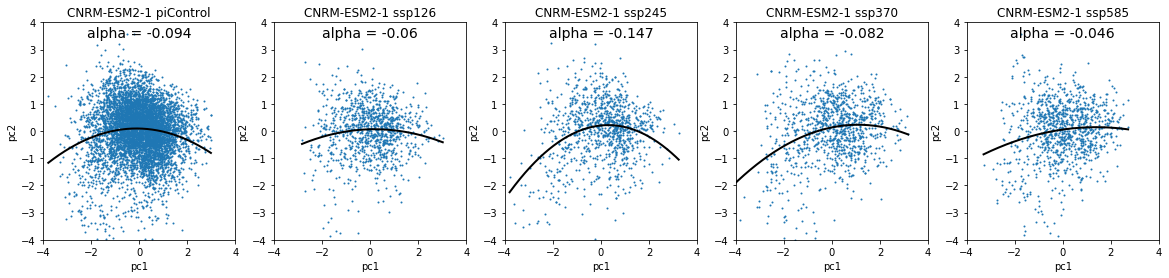

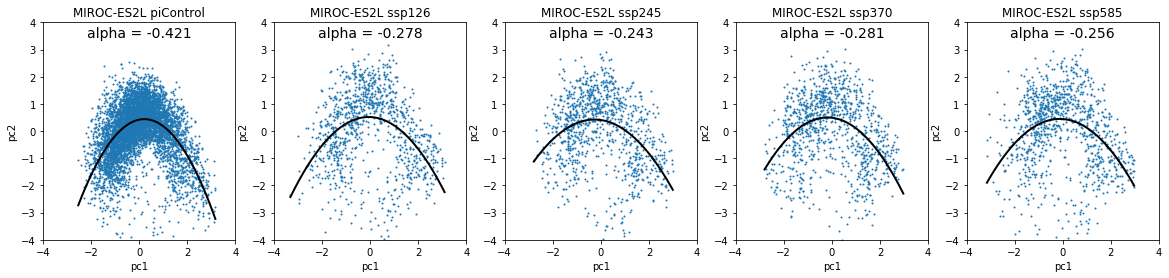

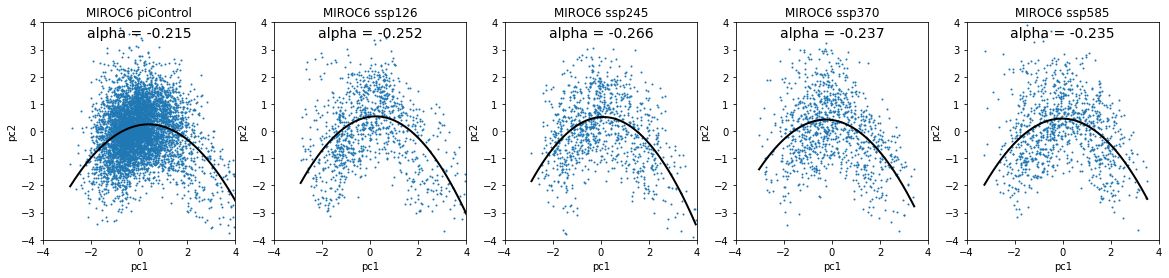

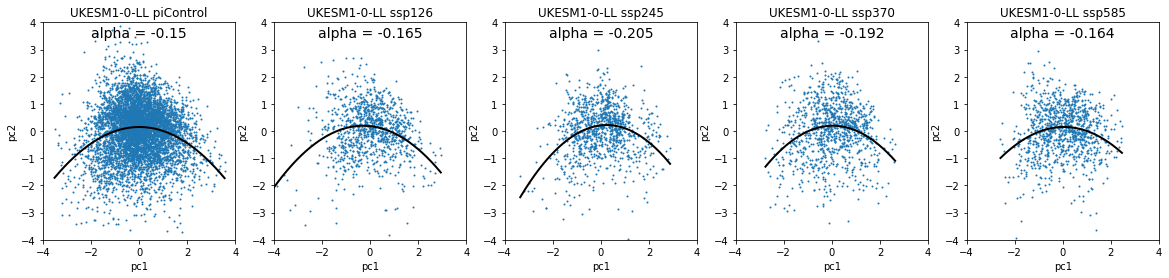

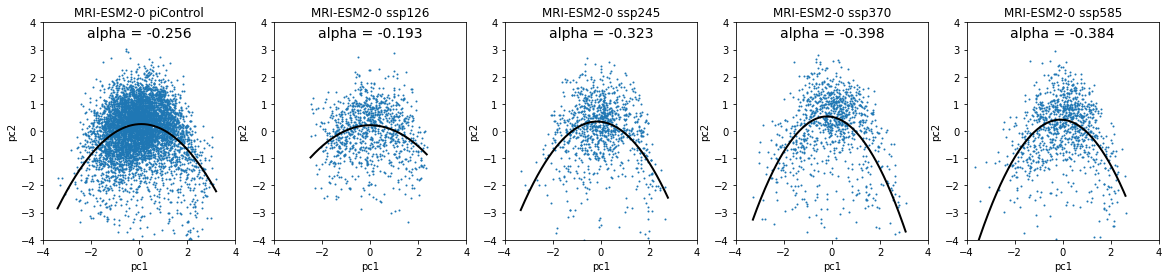

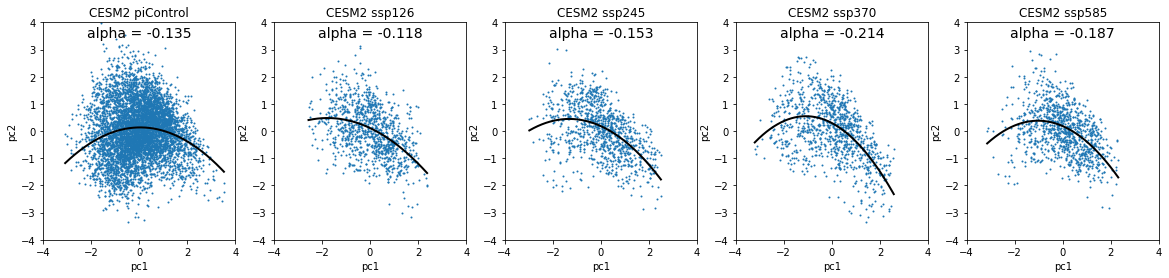

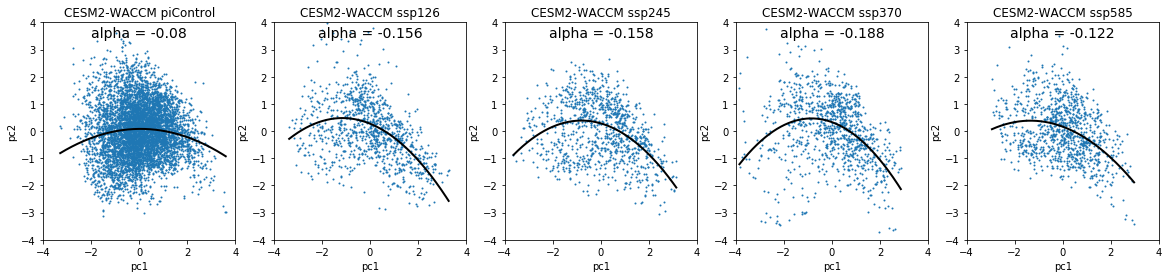

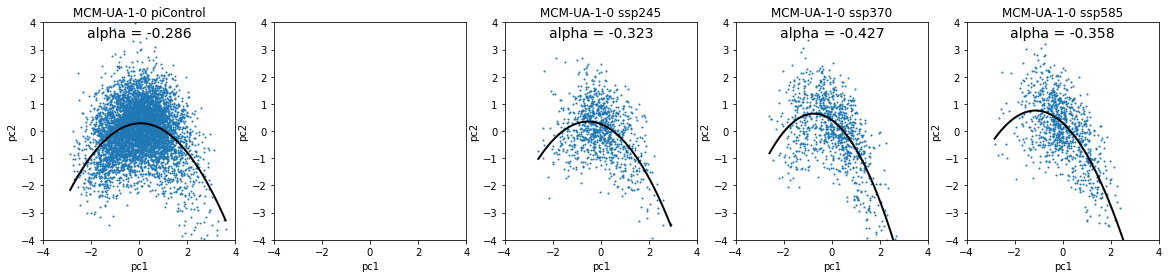

In [8]:
# save also information for use in later plots

alphas = {}
eindex_stds = {}; cindex_stds = {}; 
cindex_controlstdspread = {}; eindex_controlstdspread = {};
e_skewness = {}; c_skewness = {}

for model in models:
    alphas[model] = {}; eindex_stds[model] = {}; cindex_stds[model] = {}
    e_skewness[model] = {}; c_skewness[model] = {}; 
    cindex_controlstdspread[model] = {}; eindex_controlstdspread[model] = {};
    
    var = model + '_eofs';
    eof1 = all_eofs[var].sel(mode=0)
    eof2 = all_eofs[var].sel(mode=1)

    var2 = model + '_pcs'
    pc1 = all_pcs[var2].sel(mode=0).dropna(dim='time').values
    pc2 = all_pcs[var2].sel(mode=1).dropna(dim='time').values
    
    # make consistent signs:
    sign1 = eof_sign(eof1); sign2 = eof_sign(eof2)
    eof1 *= sign1; eof2 *= sign2
    pc1 *= sign1; pc2 *= sign2
    
    n_pc1 = pc1/pc1.std(); n_pc2 = pc2/pc2.std()
    eindex = (n_pc1 - n_pc2)/np.sqrt(2); eindex_stds[model]['piControl'] = np.std(eindex)
    cindex = (n_pc1 + n_pc2)/np.sqrt(2); cindex_stds[model]['piControl'] = np.std(cindex)
    c_skewness[model]['piControl'] = skew(cindex); e_skewness[model]['piControl'] = skew(eindex)
    
    cindex_controlstdspread[model] = std_spread(cindex)
    eindex_controlstdspread[model] = std_spread(eindex)
    
    fig, ax = plt.subplots(ncols = 5, figsize = [20,4])
    ax[0].scatter(n_pc1, n_pc2, s = 1)
    ax[0].set_title(model + ' piControl')
    
    # quadratic fit
    #x = pc1.dropna(dim='time').values; y = pc2.dropna(dim='time').values
    #x = x/np.std(x); y = y/np.std(y); x2= np.arange(min(x),max(x),0.01)
    x = n_pc1; y = n_pc2; x2= np.arange(min(x),max(x),0.01)
    p2 = np.polyfit(x, y, 2)
    #print('alpha = ', p2[0])
    qfit = np.polyval(p2, x2)
    ax[0].plot(x2, qfit, color = "black", linewidth = 2)
    ax[0].text(0.5, 0.95, 'alpha = ' + str(np.round(p2[0],3)), fontsize = 14, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes);
    alphas[model]['piControl'] = p2[0] 
    if model == 'MCM-UA-1-0': 
        exp_list = ['ssp245', 'ssp370', 'ssp585']
    else:
        exp_list = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
    
    for (i,exp) in enumerate(exp_list):
        var = model + '_' + exp + '_pseudo_pcs'
        ppc1 = sign1*all_pseudo_pcs[var].sel(mode=0)
        ppc2 = sign2*all_pseudo_pcs[var].sel(mode=1)
        n_pc1 = ppc1/pc1.std(); n_pc2 = ppc2/pc2.std()
        eindex = (n_pc1 - n_pc2)/np.sqrt(2); eindex_stds[model][exp] = np.std(eindex); 
        cindex = (n_pc1 + n_pc2)/np.sqrt(2); cindex_stds[model][exp] = np.std(cindex);
        c_skewness[model][exp] = skew(cindex); e_skewness[model][exp] = skew(eindex)
        
        x = n_pc1; y = n_pc2; 
        x2 = np.arange(min(x), max(x), 0.01)
        p2 = np.polyfit(x, y, 2)
        qfit = np.polyval(p2, x2)
        alphas[model][exp] = p2[0]
        
        if model == 'MCM-UA-1-0':
            ax[i+2].scatter(x, y, s = 1)
            ax[i+2].set_title(model + ' ' + exp)
            ax[i+2].plot(x2, qfit, color = "black", linewidth = 2)
            ax[i+2].text(0.5, 0.95, 'alpha = ' + str(np.round(p2[0],3)), fontsize = 14, horizontalalignment='center', verticalalignment='center', transform=ax[i+2].transAxes);
        else:    
            ax[i+1].scatter(x, y, s = 1)
            ax[i+1].set_title(model + ' ' + exp)
            ax[i+1].plot(x2, qfit, color = "black", linewidth = 2)
            ax[i+1].text(0.5, 0.95, 'alpha = ' + str(np.round(p2[0],3)), fontsize = 14, horizontalalignment='center', verticalalignment='center', transform=ax[i+1].transAxes);
     
    for axis in ax:
        axis.set_xlabel('pc1')
        axis.set_ylabel('pc2')
        axis.set_xlim(-4, 4)
        axis.set_ylim(-4, 4)
        


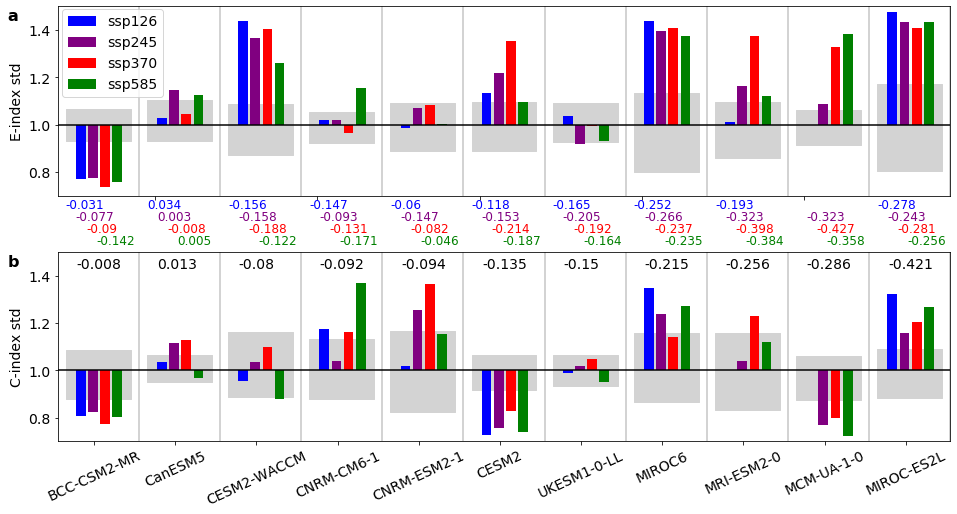

In [9]:
# change of e-index and c-index std
fig, ax = plt.subplots(nrows = 2, figsize = [16,8])
# define x-coordiates and colors for each experiment
x = {}
colors = ['black', 'blue', 'purple', 'red', 'green']
color_dict = {}
delta_x = 0.15
explist = ['piControl', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

control_alphas = [alphas[model]['piControl'] for model in models]
sorted_models = [x for _,x in sorted(zip(np.abs(control_alphas),models))]

for ind,exp in enumerate(explist):
    x[exp] = np.arange(len(sorted_models)) + 1 + delta_x*ind
    color_dict[exp] = colors[ind]
    
for (k, model) in enumerate(sorted_models):
    if model == 'MCM-UA-1-0': 
        exp_list = ['ssp245', 'ssp370', 'ssp585']
    else:
        exp_list = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
    
    for (i,exp) in enumerate(exp_list):

        e_std = eindex_stds[model][exp] - eindex_stds[model]['piControl']
        c_std = cindex_stds[model][exp] - cindex_stds[model]['piControl']
        ax[0].axvline(x['piControl'][k]+0.8, color='lightgray')
        ax[1].axvline(x['piControl'][k]+0.8, color='lightgray')
        
        if k == 0:
            # then define labels for experiments
            ax[0].bar(x[exp][k]-0.065, e_std, width = 0.12, bottom = 1, color=color_dict[exp], label = exp)
            ax[1].bar(x[exp][k]-0.065, c_std, width = 0.12, bottom = 1, color=color_dict[exp], label = exp)
        else: 
            ax[0].bar(x[exp][k]-0.065, e_std, width = 0.12, bottom = 1, color=color_dict[exp])
            ax[1].bar(x[exp][k]-0.065, c_std, width = 0.12, bottom = 1, color=color_dict[exp])
            
        if i == 0:
            c_spread = cindex_controlstdspread[model]; e_spread = eindex_controlstdspread[model];
            ax[0].fill_between([x['piControl'][k]-0.1, x['piControl'][k] + 0.7], e_spread[0], e_spread[1], color = "lightgray")
            ax[1].fill_between([x['piControl'][k]-0.1, x['piControl'][k] + 0.7], c_spread[0], c_spread[1], color = "lightgray")
        
        if model == 'MCM-UA-1-0': 
            i += 1     
        ax[1].text(x['piControl'][k]-0.1+i/8, 1.7-i/20, str(np.round(alphas[model][exp],3)), color=color_dict[exp], fontsize = 12, verticalalignment='center')
    ax[1].text(x['piControl'][k]+0.03, 1.45, str(np.round(alphas[model]['piControl'],3)), color='black', fontsize = 14, verticalalignment='center')
for axis in ax:
    axis.tick_params(axis='both',labelsize=14)
    axis.set_xlim(0.8, 11.8)
    axis.plot([0.8, 11.8], [1, 1], color = "black")
    axis.set_ylim(0.7, 1.5)
    axis.set_xticklabels([])
    
ax[0].set_ylabel('E-index std', fontsize = 14)   
ax[1].set_ylabel('C-index std', fontsize = 14)  
ax[0].legend(loc=(0.005,0.52), fontsize = 14);
    
plt.subplots_adjust(hspace=0.3)
plt.xticks(x['piControl']+0.25, sorted_models, rotation=25);
plt.text(-0.05, 0.95, 'a', fontweight = 'bold', fontsize = 16, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes);
plt.text(-0.05, 0.95, 'b', fontweight = 'bold', fontsize = 16, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes);

#plt.savefig('../Figures/Figure3.png', format='png', dpi=300, bbox_inches="tight")


## Alpha vs skewness of E-index and C-index (piControl)

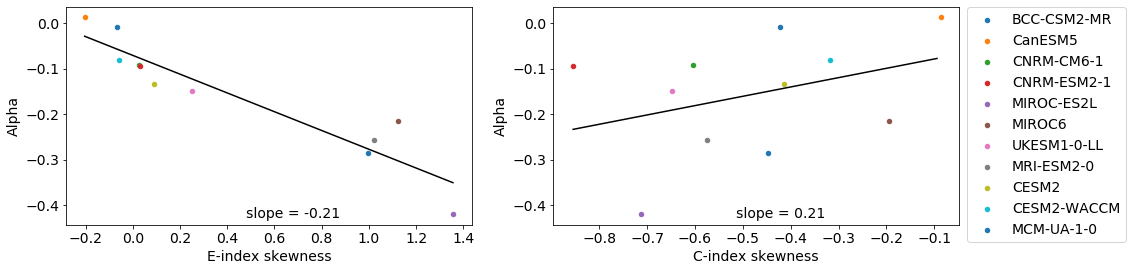

In [35]:
fig, ax = plt.subplots(ncols = 2, figsize = [16,4])

e_skew = {}; c_skew = {}
for model in models:
    var = model + '_eofs';
    eof1 = all_eofs[var].sel(mode=0)
    eof2 = all_eofs[var].sel(mode=1)

    var2 = model + '_pcs'
    pc1 = all_pcs[var2].sel(mode=0).dropna(dim='time').values
    pc2 = all_pcs[var2].sel(mode=1).dropna(dim='time').values
    
    # make consistent signs:
    sign1 = eof_sign(eof1); sign2 = eof_sign(eof2)
    eof1 *= sign1; eof2 *= sign2
    pc1 *= sign1; pc2 *= sign2
    
    n_pc1 = pc1/pc1.std(); n_pc2 = pc2/pc2.std()
    eindex = (n_pc1 - n_pc2)/np.sqrt(2)
    cindex = (n_pc1 + n_pc2)/np.sqrt(2)
    e_skew[model]  = skew(eindex); c_skew[model]  = skew(cindex)
    # quadratic fit
    x = n_pc1; y = n_pc2
    #x2= np.arange(min(x),max(x),0.01)
    p2 = np.polyfit(x, y, 2)
    alpha = p2[0]  
    ax[0].scatter(e_skew[model], alpha, s = 20); ax[0].set_xlabel('E-index skewness', fontsize = 14)
    ax[1].scatter(c_skew[model], alpha, s = 20, label = model); ax[1].set_xlabel('C-index skewness', fontsize = 14)

for axis in ax:
    axis.set_ylabel('Alpha', fontsize = 14)
    axis.tick_params(axis='both',labelsize=14)
ax[1].legend(loc=(1.02,-0.08), fontsize = 14)

# linear fit in left plot
x = list(e_skew.values()); y = [alphas[model]['piControl'] for model in models]
pe = np.polyfit(x, y, 1)
x2 = np.arange(min(x), max(x), 0.01)
ax[0].plot(x2, np.polyval(pe, x2), color = "black")
ax[0].text(0.56, 0.05, 'slope = ' + str(np.round(pe[0],2)), fontsize = 14, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)

# linear fit in right plot
x = list(c_skew.values()); y = [alphas[model]['piControl'] for model in models]
pc = np.polyfit(x, y, 1)
x2 = np.arange(min(x), max(x), 0.01)
ax[1].plot(x2, np.polyval(pc, x2), color = "black")
ax[1].text(0.56, 0.05, 'slope = ' + str(np.round(pc[0],2)), fontsize = 14, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes);



## Repeat figure and include also points for all future scenarios

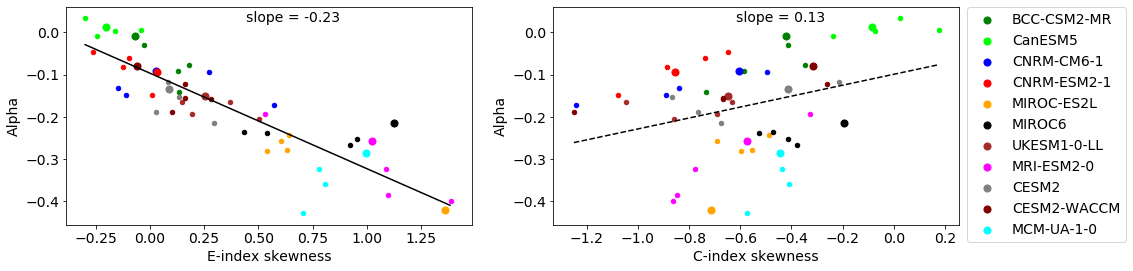

In [36]:
fig, ax = plt.subplots(ncols = 2, figsize = [16,4])
color_list = ['Green', 'Lime', 'Blue', 'Red', 'Orange', 'Black', 'Brown', 'Magenta', 'Grey', 'Maroon', 'Cyan']
colors = {}  
for (i,model) in enumerate(models):
    colors[model] = color_list[i]
    
    if model == 'MCM-UA-1-0': 
        exp_list = ['piControl','ssp245', 'ssp370', 'ssp585']
    else:
        exp_list = ['piControl','ssp126', 'ssp245', 'ssp370', 'ssp585']
        
    for (k,exp) in enumerate(exp_list):
        alpha = alphas[model][exp]
        e_skew = e_skewness[model][exp]; c_skew = c_skewness[model][exp];
        
        ax[0].scatter(e_skew, alpha, s = 20, color = color_list[i]); ax[0].set_xlabel('E-index skewness', fontsize = 14)
        if k == 0:
            ax[0].scatter(e_skew, alpha, s = 50, color = color_list[i]); ax[0].set_xlabel('E-index skewness', fontsize = 14)
            ax[1].scatter(c_skew, alpha, s = 50, label = model, color = color_list[i]); ax[1].set_xlabel('C-index skewness', fontsize = 14)
        else:
            ax[1].scatter(c_skew, alpha, s = 20, color = color_list[i]); ax[1].set_xlabel('C-index skewness', fontsize = 14)
        
for axis in ax:
    axis.set_ylabel('Alpha', fontsize = 14)
    axis.tick_params(axis='both',labelsize=14)
ax[1].legend(loc=(1.02,-0.08), fontsize = 14)

e_list = []; c_list = []; alpha_list = []
for key, value in e_skewness.items():
    e_list = np.concatenate([e_list, list(value.values())])
for key, value in c_skewness.items():
    c_list = np.concatenate([c_list, list(value.values())])
for key, value in alphas.items():
    alpha_list = np.concatenate([alpha_list, list(value.values())])

# linear fit in left plot
x = e_list; y = alpha_list
pe = np.polyfit(x, y, 1)
x2 = np.arange(min(x), max(x), 0.01)
ax[0].plot(x2, np.polyval(pe, x2), color = "black")
ax[0].text(0.56, 0.95, 'slope = ' + str(np.round(pe[0],2)), fontsize = 14, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)

# linear fit in right plot
x = c_list; y = alpha_list
pc = np.polyfit(x, y, 1)
x2 = np.arange(min(x), max(x), 0.01)
ax[1].plot(x2, np.polyval(pc, x2), '--', color = "black")
ax[1].text(0.56, 0.95, 'slope = ' + str(np.round(pc[0],2)), fontsize = 14, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes);



## Repeat analysis above for standard deviation instead of skewness

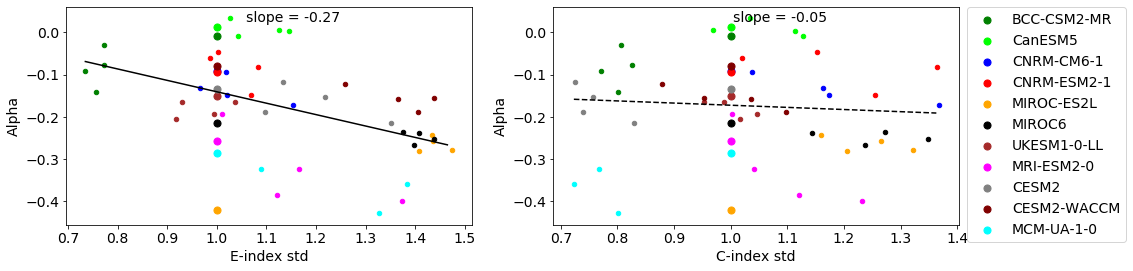

In [37]:
fig, ax = plt.subplots(ncols = 2, figsize = [16,4])
color_list = ['Green', 'Lime', 'Blue', 'Red', 'Orange', 'Black', 'Brown', 'Magenta', 'Grey', 'Maroon', 'Cyan']
colors = {}  
for (i,model) in enumerate(models):
    colors[model] = color_list[i]
    
    if model == 'MCM-UA-1-0': 
        exp_list = ['piControl','ssp245', 'ssp370', 'ssp585']
    else:
        exp_list = ['piControl','ssp126', 'ssp245', 'ssp370', 'ssp585']
        
    for (k,exp) in enumerate(exp_list):
        alpha = alphas[model][exp]
        e_std = eindex_stds[model][exp]; c_std = cindex_stds[model][exp];
        
        ax[0].scatter(e_std, alpha, s = 20, color = color_list[i])
        if k == 0:
            ax[0].scatter(e_std, alpha, s = 50, color = color_list[i]); ax[0].set_xlabel('E-index std', fontsize = 14)
            ax[1].scatter(c_std, alpha, s = 50, label = model, color = color_list[i]); ax[1].set_xlabel('C-index std', fontsize = 14)
        else:
            ax[1].scatter(c_std, alpha, s = 20, color = color_list[i])
        
for axis in ax:
    axis.set_ylabel('Alpha', fontsize = 14)
    axis.tick_params(axis='both',labelsize=14)
ax[1].legend(loc=(1.02,-0.08), fontsize = 14)

e_list = []; c_list = []; alpha_list = []
for key, value in eindex_stds.items():
    e_list = np.concatenate([e_list, list(value.values())])
for key, value in cindex_stds.items():
    c_list = np.concatenate([c_list, list(value.values())])
for key, value in alphas.items():
    alpha_list = np.concatenate([alpha_list, list(value.values())])

# linear fit in left plot
x = e_list; y = alpha_list
pe = np.polyfit(x, y, 1)
x2 = np.arange(min(x), max(x), 0.01)
ax[0].plot(x2, np.polyval(pe, x2), color = "black")
ax[0].text(0.56, 0.95, 'slope = ' + str(np.round(pe[0],2)), fontsize = 14, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)

# linear fit in right plot
x = c_list; y = alpha_list
pc = np.polyfit(x, y, 1)
x2 = np.arange(min(x), max(x), 0.01)
ax[1].plot(x2, np.polyval(pc, x2), '--', color = "black")
ax[1].text(0.56, 0.95, 'slope = ' + str(np.round(pc[0],2)), fontsize = 14, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes);



## Patterns computed by regressing on C-index and E-index

Results obtained using all monthly values, in contrast to Cai et al. who used only DJF means. The plots are currently based on linear regressions with only C-index or only E-index, rather than a bi-linear regression. But it doesn't seem like the results are very sensitive to this choice, when comparing with analyses below.

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
Reuse existing file: bilinear_36x134_30x140.nc
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
Reuse existing file: bilinear_14x54_30x140.nc
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
Reuse existing file: bilinear_28x107_30x140.nc
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
Reuse existing file: bilinear_28x107_30x140.nc
--> The keys in the returned dictionary of datasets are constructed as follow

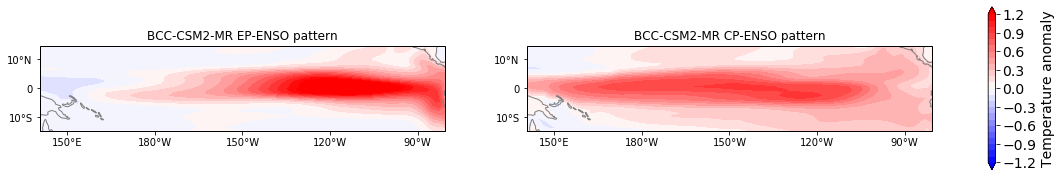

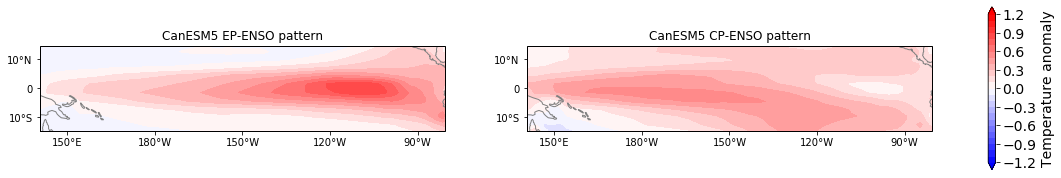

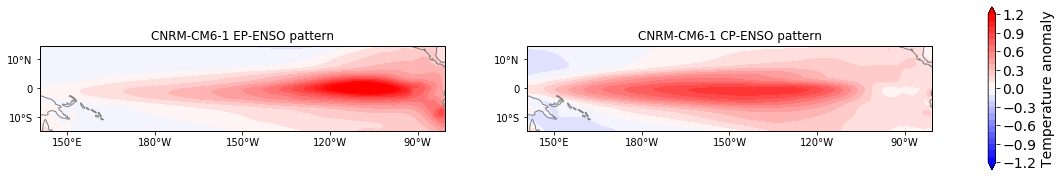

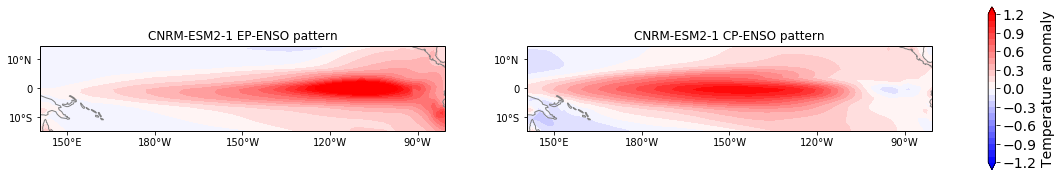

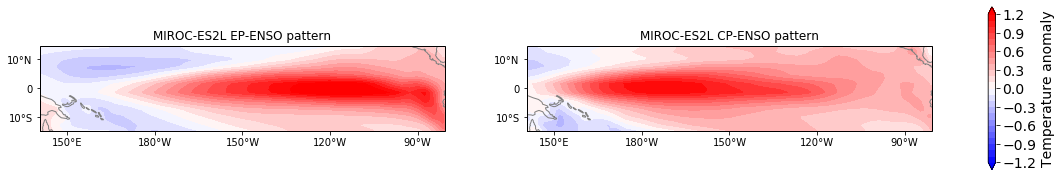

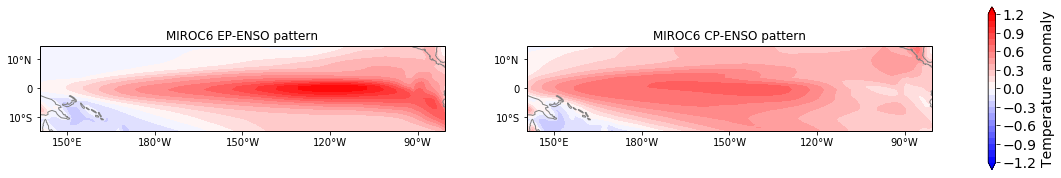

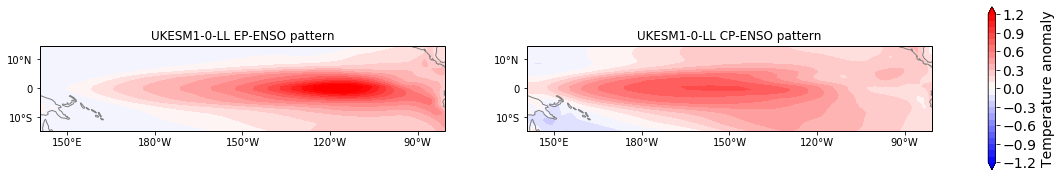

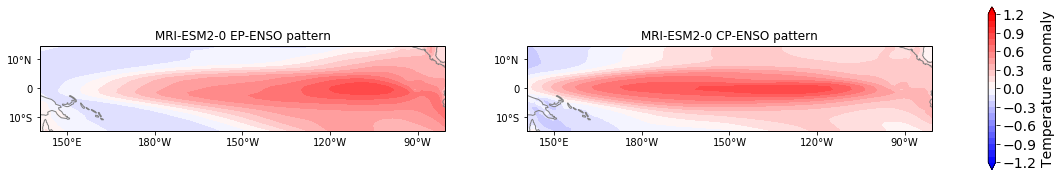

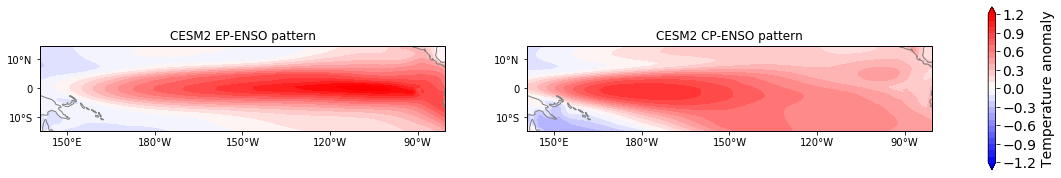

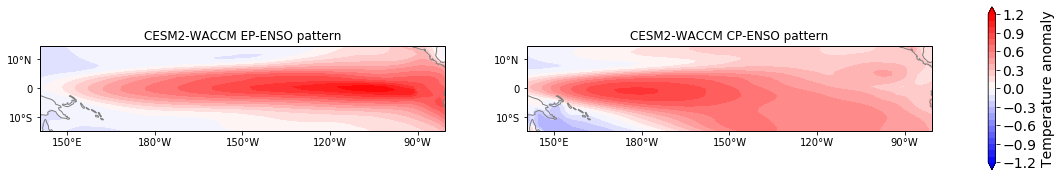

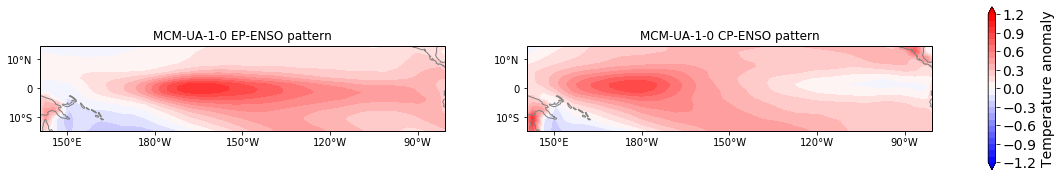

In [38]:
# use larger region before regridding, that adds 5 deg to each border:
latregion = slice(-15,15); lonregion = slice(140, 280) # = 140 E - 80 W
larger_latregion = slice(-20,20); larger_lonregion = slice(135, 285)
resolution = 1;
ds_out = xr.Dataset({'lon': (['lon'], np.arange(lonregion.start+resolution/2, lonregion.stop+resolution/2, resolution)),
                     'lat': (['lat'], np.arange(latregion.start+resolution/2, latregion.stop+resolution/2, resolution))
                    }
                   )
for model in models:
    var = model + '_eofs';
    eof1 = all_eofs[var].sel(mode=0)
    eof2 = all_eofs[var].sel(mode=1)

    var2 = model + '_pcs'
    pc1 = all_pcs[var2].sel(mode=0)
    pc2 = all_pcs[var2].sel(mode=1)
    
    # make consistent signs:
    sign1 = eof_sign(eof1); sign2 = eof_sign(eof2)
    eof1 *= sign1; eof2 *= sign2
    pc1 *= sign1; pc2 *= sign2
    
    n_pc1 = pc1/pc1.std(); n_pc2 = pc2/pc2.std()
    eindex = (n_pc1 - n_pc2)/np.sqrt(2)
    cindex = (n_pc1 + n_pc2)/np.sqrt(2)
    
    # load piControl data
    member = picontrol_member(model)
    cat = col.search(experiment_id = 'piControl', source_id = model, variable_id='ts', table_id='Amon', member_id = member)
    dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})
    for key in dset_dict.keys():
        ds = dset_dict[key].sel(member_id = member)
    if model == 'MCM-UA-1-0':
        ds = ds.rename({'longitude': 'lon','latitude': 'lat'})
    regional_data = ds.ts.sel(lat = larger_latregion, lon = larger_lonregion)
    regridder = xe.Regridder(regional_data, ds_out, 'bilinear', reuse_weights = True)
    regridded_data = regridder(regional_data)

    # linear detrending for first 500 years:
    ds_detr = xr.apply_ufunc(detrend, regridded_data[:500*12], kwargs={'axis': 0}, dask = 'allowed')

    # deseasonalise
    ts_clim = ds_detr.groupby('time.month').mean(dim='time')
    ts_anom = ds_detr.groupby('time.month') - ts_clim
    
    # do regressions
    dataset = ts_anom.stack(grid_cells=('lon', 'lat'))
    p_e = np.polyfit(eindex.dropna(dim = 'time'), dataset, deg=1); p_c = np.polyfit(cindex.dropna(dim = 'time'), dataset, deg=1);
    e_pattern_da = xr.DataArray(p_e[0], coords = {'grid_cells': dataset.grid_cells}, dims = ['grid_cells'])
    c_pattern_da = xr.DataArray(p_c[0], coords = {'grid_cells': dataset.grid_cells}, dims = ['grid_cells'])
    e_pattern = e_pattern_da.unstack('grid_cells'); c_pattern = c_pattern_da.unstack('grid_cells'); 
    #pattern_ds = pattern_da.to_dataset(name = 'eindex_pattern').unstack('grid_cells')
    
    fig, ax = plt.subplots(ncols = 2, figsize = [20,3], subplot_kw={'projection': data_crs})
    
    cs0 = ax[0].contourf(ts_anom.lon, ts_anom.lat, (e_pattern).transpose(), np.arange(-maxval,maxval+step,step), cmap = 'bwr',extend='both', transform=ccrs.PlateCarree())
    cs1 = ax[1].contourf(ts_anom.lon, ts_anom.lat, (c_pattern).transpose(), np.arange(-maxval,maxval+step,step), cmap = 'bwr',extend='both', transform=ccrs.PlateCarree())
    for i in [0,1]:
        ax[i].coastlines(color='gray')
    cbar = fig.colorbar(cs1, ax = ax.ravel().tolist(), orientation="vertical")
    cbar.set_label('Temperature anomaly', fontsize = 14)
    cbar.ax.tick_params(labelsize = 14)
    
    ax[0].set_title(model + ' EP-ENSO pattern')
    ax[1].set_title(model + ' CP-ENSO pattern')
    
    plt.setp(ax, xticks = np.arange(150, 280, 30)-180, xticklabels = ['150°E', '180°W', '150°W', '120°W', '90°W'])
    plt.setp(ax, yticks = [-10, 0, 10], yticklabels = ['10°S', '0', '10°N'])
    
    

## Alternative way of finding patterns associated with C-index and E-index

Using all monthly data, patterns can be defined such that:

EOF1 * PC1 + EOF2 * PC2   =   C-index * CP-ENSO pattern + E-index * EP-ENSO pattern

Results of this should be very close (or equal?) to a bi-linear regression

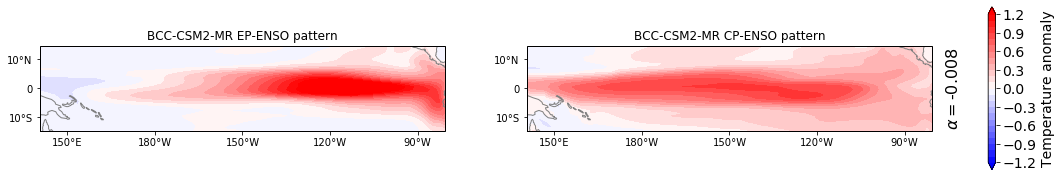

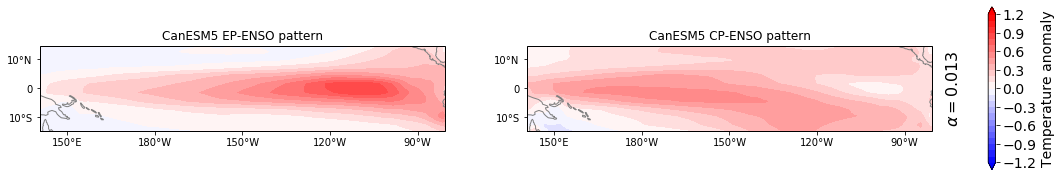

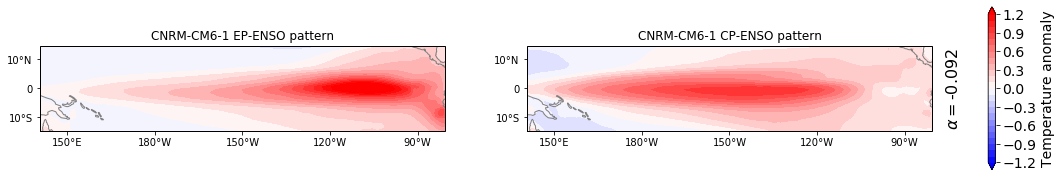

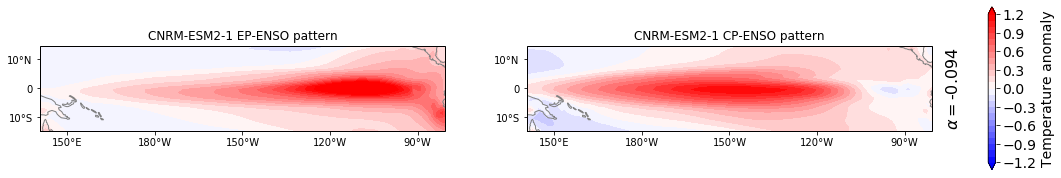

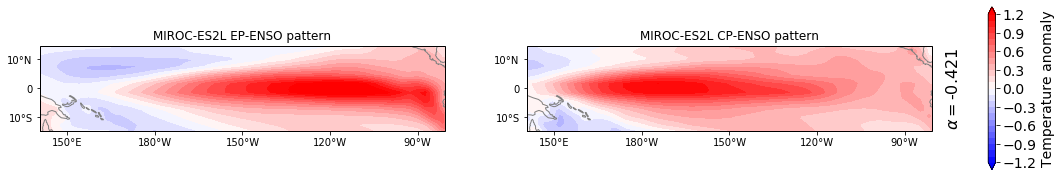

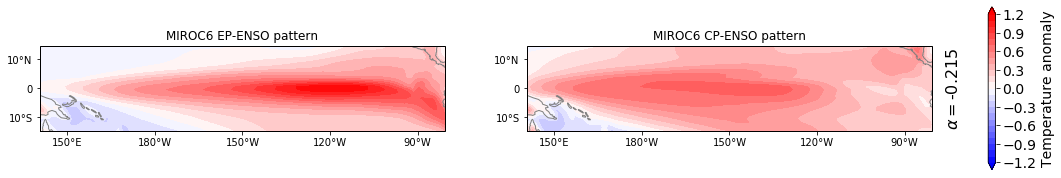

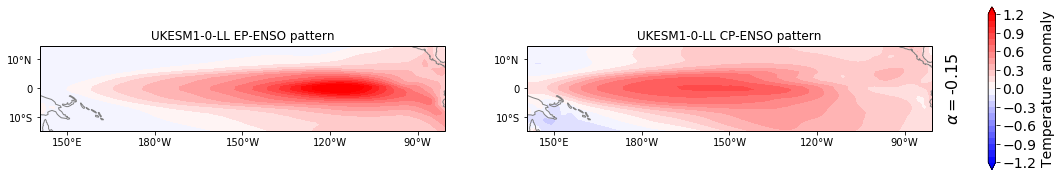

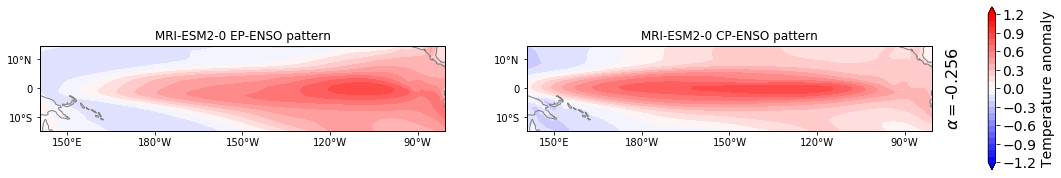

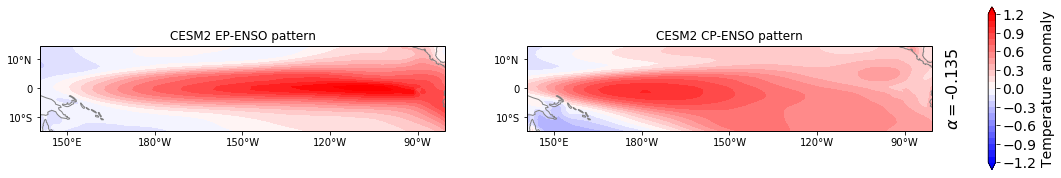

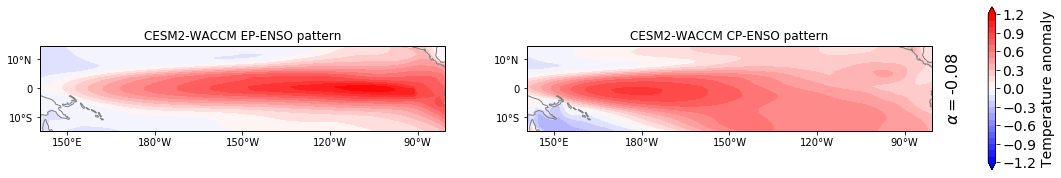

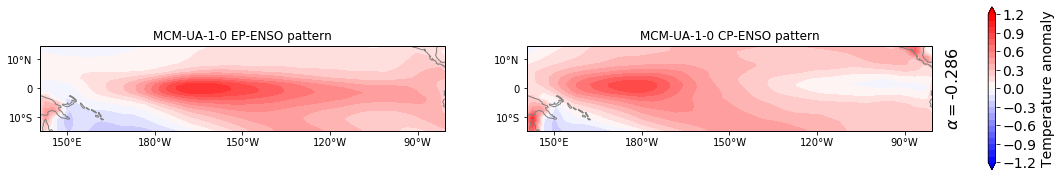

In [39]:

maxval = 1.2; step = 0.1
data_crs = ccrs.PlateCarree(central_longitude=180.0)

for model in models:
    var = model + '_eofs'; var_frac = model + '_variance_fractions'
    eof1 = all_eofs[var].sel(mode=0); var_frac1 = all_variance_fractions[var_frac].sel(mode=0).values
    eof2 = all_eofs[var].sel(mode=1); var_frac2 = all_variance_fractions[var_frac].sel(mode=1).values
    
    var2 = model + '_pcs'
    pc1 = all_pcs[var2].sel(mode=0)
    pc2 = all_pcs[var2].sel(mode=1)
    
    # make consistent signs:
    sign1 = eof_sign(eof1); sign2 = eof_sign(eof2)
    eof1 *= sign1; eof2 *= sign2
    pc1 *= sign1; pc2 *= sign2
    
    ep_enso = np.sqrt(2)/2*(eof1*pc1.std() - eof2*pc2.std())
    cp_enso = np.sqrt(2)/2*(eof1*pc1.std() + eof2*pc2.std())
    
    fig, ax = plt.subplots(ncols = 2, figsize = [20,3], subplot_kw={'projection': data_crs})
    
    cs0 = ax[0].contourf(all_eofs.lon, all_eofs.lat, (ep_enso).transpose(), np.arange(-maxval,maxval+step,step), cmap = 'bwr',extend='both', transform=ccrs.PlateCarree())
    cs1 = ax[1].contourf(all_eofs.lon, all_eofs.lat, (cp_enso).transpose(), np.arange(-maxval,maxval+step,step), cmap = 'bwr',extend='both', transform=ccrs.PlateCarree())
    for i in [0,1]:
        ax[i].coastlines(color='gray')
    cbar = fig.colorbar(cs1, ax = ax.ravel().tolist(), orientation="vertical")
    cbar.set_label('Temperature anomaly', fontsize = 14)
    cbar.ax.tick_params(labelsize = 14)
    
    ax[0].set_title(model + ' EP-ENSO pattern')
    ax[1].set_title(model + ' CP-ENSO pattern')
    #ax[1].text(alphas[model]['piControl'])
    ax[1].text(1.05, 0.5, r'$\alpha = $' + str(np.round(alphas[model]['piControl'],3)), fontsize = 16, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, rotation = 90);
    
    plt.setp(ax, xticks = np.arange(150, 280, 30)-180, xticklabels = ['150°E', '180°W', '150°W', '120°W', '90°W'])
    plt.setp(ax, yticks = [-10, 0, 10], yticklabels = ['10°S', '0', '10°N'])
    